In [1]:
# import torch and numpy and pretrained model
from torchvision import models
import torch
import numpy as np
import os

# load pretrained model
pretrained_model = models.resnet50(weights = 'DEFAULT', progress = True)

In [2]:
# changes fully connected/classifier layer to new layer for us to train, 15 is the number of solutions or types of leaves
pretrained_model.fc = torch.nn.Linear(2048, 15)

In [3]:
# # Currently not in use, for if we wanna custom build a softmax but idk how to train it
# import torch.nn as nn
# # build custom softmax module
# class Softmax(nn.Module):
#     def __init__(self, n_inputs, n_outputs):
#         super().__init__()
#         self.linear = nn.Linear(n_inputs, n_outputs)
 
#     def forward(self, x):
#         pred = self.linear(x)
#         return pred

In [4]:
# # Currently not in use
# # adds softmax to model
# class MyModel(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyModel, self).__init__()
#         self.pretrained_model = pretrained_model
#         self.last_layer = Softmax(1000, n) # add how many nodes as input and output

#     def forward(self, x):
#         return self.last_layer(self.pretrained_model(x))

# model = MyModel(pretrained_model)

In [5]:
#freeze model except fc layer because we don't wanna retrain the pretrained model
for param in pretrained_model.parameters():
    param.requires_grad = False

for param in pretrained_model.fc.parameters():
    param.requires_grad = True

In [6]:
criterion = torch.nn.CrossEntropyLoss() #could write this out ourselves
# need to find an optimizer or make one for a custom softmax function
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001) #need optimize learning rate idk how momentum works

In [7]:
#import data
from PIL import Image
import os
from sklearn.preprocessing import OneHotEncoder
data_dir = "/Users/stevenli/SigAida/data/images/" #change to data directory

# gets the label based on the number
def getLabel(s):
    labels = {1 : 'Ulmus carpinifolia', 
                2 : 'Acer', 
                3 : 'Salix aurita', 
                4 : 'Quercus', 
                5 : 'Alnus incan', 
                6 : 'Betula pubescens', 
                7 : 'Salix alba \'Sericea\'', 
                8 : 'Populus tremula', 
                9 : 'Ulmus glabra', 
                10 : 'Sorbus aucuparia', 
                11 : 'Salix sinerea', 
                12 : 'Populus', 
                13 : 'Tilia', 
                14 : 'Sorbus intermedia', 
                15 : 'Fagus silvatica'}
    return labels.get(int(s))

im = [] # images
la = [] # labels not in use, because you can't feed strings to gpu, need to feed tensors
ohe = [] #s toring int values for one hot encodings
joined = []

for f in os.listdir(data_dir):
    im.append(data_dir + f)
    print(f)
    val = int(f[:-9].replace('l','')) # removes last 9 letters replaces l with blank then gets label
    la.append(getLabel(val)) 
    ohe.append(val)

#one hot encoding (changing 1-15 to tensors for gpu)
encoded = OneHotEncoder(categories = [[x for x in range(1, 16)]], sparse = False).fit_transform(np.array(ohe).reshape((len(ohe),1)))
# print(encoded)

#joining image and label for organization and if we wanna shuffle
for image, label in zip(im, encoded):
    joined.append([image, label])

# print(la)
# print(im)
# print(joined[1])

l8nr039.tif
l9nr039.tif
l9nr011.tif
l8nr005.tif
l8nr011.tif
l9nr005.tif
l10nr050.tif
l11nr044.tif
l11nr050.tif
l10nr044.tif
l3nr006.tif
l2nr012.tif
l2nr006.tif
l3nr012.tif
l1nr055.tif
l1nr041.tif
l12nr003.tif
l1nr069.tif
l13nr017.tif
l13nr003.tif
l12nr017.tif
l5nr063.tif
l4nr063.tif
l6nr018.tif
l15nr072.tif
l14nr066.tif
l7nr018.tif
l14nr072.tif
l15nr066.tif
l6nr024.tif
l7nr030.tif
l7nr024.tif
l6nr030.tif
l7nr025.tif
l6nr031.tif
l6nr025.tif
l7nr031.tif
l14nr073.tif
l7nr019.tif
l15nr067.tif
l15nr073.tif
l6nr019.tif
l14nr067.tif
l4nr062.tif
l5nr062.tif
l13nr002.tif
l12nr016.tif
l1nr068.tif
l12nr002.tif
l13nr016.tif
l1nr040.tif
l1nr054.tif
l2nr007.tif
l3nr013.tif
l3nr007.tif
l2nr013.tif
l11nr051.tif
l10nr045.tif
l10nr051.tif
l11nr045.tif
l8nr010.tif
l9nr004.tif
l9nr010.tif
l8nr004.tif
l9nr038.tif
l8nr038.tif
l9nr006.tif
l8nr012.tif
l8nr006.tif
l9nr012.tif
l10nr047.tif
l11nr053.tif
l2nr039.tif
l11nr047.tif
l10nr053.tif
l3nr039.tif
l3nr011.tif
l2nr005.tif
l2nr011.tif
l3nr005.tif
l12nr028.tif

/Users/stevenli/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# some preprocessing, randomize data, split data, load into dataloaders
import random

# splits (train, val, test) test currently not in use
split_ratio=(0.8, 0.1, 0.1)

def create_splits(data, split_ratio):
    random.shuffle(data)
    train = [data[i] for i in range(0, round(.8 * len(data)))]
    val = [data[i] for i in range(round(.8 * len(data)), round(.9 * len(data)))]
    test = [data[i] for i in range(round(.9 * len(data)), len(data))]
    return train, val, test

train, val, test = create_splits(joined, split_ratio)

print(len(joined))
print(len(train))
print(len(val))
print(len(test))

1125
900
112
113


In [20]:
#making dataset
from torch.utils.data import Dataset

#prevents some truncated bs
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# makes a custom dataset based on pytorch dataset class
class PlantDataset(Dataset):
    def __init__(self, data_dir, arr, transform = None, augment = None):
        # initialize some valuess
        self.data_dir = data_dir
        self.data = [x[0] for x in arr]
        self.augments = augment
        #transform to normalize/resize all images
        self.transform = transform

        #apply augment and transforms
        self.arr = self.augment(arr, self.augments, self.transform, data_dir) 

    # data augmentation helper function
    def augment(self, arr, augments, transform, data_dir):
        a = []
        for (f, l) in arr:
            img = transform(Image.open(f))
            a.append((img, l))
            
            n = 5 # of multiples
            if augments:
                for i in range(n):
                    a.append((augments(img), l))
        return a
            


        # ims = [Image.open(i[0]) for i in arr]
        # # print(len(ims))
        # lbs = [i[1] for i in arr]

        # #transform and write out into data_dir then concatenate to arr with original label
        # n = 3 #how many x do you want to make the data
        # counter = 1
        # for im, lb in zip(ims, lbs):
        #     for j in range(n):
        #         temp = transforms(im)
        #         filename = data_dir + str(counter) + "image" + str(j) + "version" + str(np.where(lb == 1)[0][0] + 1) + "label.tif"
        #         temp.save(filename)
        #         temp.close()

        #         arr.append((filename, lb))
        #     counter += 1
        # return arr
    
    def __len__(self):
        return len(self.arr)
    
    def __getitem__(self, idx):
        img = self.arr[idx][0]
        s = self.arr[idx][1]
        #returns a tuple of the transformed image and the label (one-hot encoding)
        return (img, s)

In [10]:
import torchvision.transforms as transforms

#defining our transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)), # change to what data should be
    transforms.ToTensor(),
    ])

#list of augments, rotation, affine (translation)
augments = transforms.Compose([transforms.Resize((224, 224)),
                              transforms.RandomRotation(8,fill=0),
                              transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0)]) 

#making dataset and dataloader
train_dataset = PlantDataset(data_dir, train, transform = transform, augment=augments) #probably need to make this bigger
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [11]:
print(len(train_dataset))

5400


In [12]:
#chcek devices change to whatever you're using

#mps = (m1/m2 mac) gpu

print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

#set device
device = torch.device('mps')

from tqdm import tqdm # progress

True
True


In [13]:
#testing accuracy on test dataset
total_correct = 0
total_instances = 0

pretrained_model.eval()
# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(train_loader):
      pretrained_model.to(device)
      images = images.to(device)
      # labels = labels.float().to(device) # don't need this cuz we not training no more

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print("basline before training")
print(round(total_correct/total_instances, 3))

100%|██████████| 5400/5400 [02:33<00:00, 35.07it/s]

basline before training
0.144


In [14]:
# Train the model
pretrained_model.train()
num_epochs = 50

#store loss
loss_history = []

#change batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    for data, label in tqdm(train_loader):
        # Move tensors to the configured device
        pretrained_model.to(device)
        images = data.to(device)
        labels = label.float().to(device) #.float() for some float64, float32 conversion thing, don't completely understand

        optimizer.zero_grad()
        
        # Forward pass
        outputs = pretrained_model(images) #currently image tensor don't match fc layer if you use non pretrained model
        loss = criterion(outputs, labels) #calculate loss

        # Backward and optimize don't really understand this stuff
        loss.backward()
        optimizer.step()

        # Print some statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

100%|██████████| 169/169 [00:30<00:00,  5.50it/s]


Epoch [1/50], Loss: 0.2672


100%|██████████| 169/169 [00:22<00:00,  7.65it/s]


Epoch [2/50], Loss: 0.1454


100%|██████████| 169/169 [00:21<00:00,  7.78it/s]


Epoch [3/50], Loss: 0.0500


100%|██████████| 169/169 [00:23<00:00,  7.25it/s]


Epoch [4/50], Loss: 0.0488


100%|██████████| 169/169 [00:21<00:00,  7.73it/s]


Epoch [5/50], Loss: 0.0105


100%|██████████| 169/169 [00:22<00:00,  7.51it/s]


Epoch [6/50], Loss: 0.0261


100%|██████████| 169/169 [00:21<00:00,  7.81it/s]


Epoch [7/50], Loss: 0.0235


100%|██████████| 169/169 [00:21<00:00,  7.79it/s]


Epoch [8/50], Loss: 0.0274


100%|██████████| 169/169 [00:22<00:00,  7.63it/s]


Epoch [9/50], Loss: 0.0111


100%|██████████| 169/169 [00:21<00:00,  7.82it/s]


Epoch [10/50], Loss: 0.0094


100%|██████████| 169/169 [00:21<00:00,  7.82it/s]


Epoch [11/50], Loss: 0.0053


100%|██████████| 169/169 [00:22<00:00,  7.38it/s]


Epoch [12/50], Loss: 0.0174


100%|██████████| 169/169 [00:22<00:00,  7.64it/s]


Epoch [13/50], Loss: 0.0068


100%|██████████| 169/169 [00:22<00:00,  7.65it/s]


Epoch [14/50], Loss: 0.0366


100%|██████████| 169/169 [00:21<00:00,  7.83it/s]


Epoch [15/50], Loss: 0.0195


100%|██████████| 169/169 [00:22<00:00,  7.51it/s]


Epoch [16/50], Loss: 0.0098


100%|██████████| 169/169 [00:22<00:00,  7.60it/s]


Epoch [17/50], Loss: 0.0041


100%|██████████| 169/169 [00:21<00:00,  7.78it/s]


Epoch [18/50], Loss: 0.0079


100%|██████████| 169/169 [00:21<00:00,  7.79it/s]


Epoch [19/50], Loss: 0.0085


100%|██████████| 169/169 [00:24<00:00,  7.00it/s]


Epoch [20/50], Loss: 0.0051


100%|██████████| 169/169 [00:21<00:00,  7.82it/s]


Epoch [21/50], Loss: 0.0047


100%|██████████| 169/169 [00:21<00:00,  7.81it/s]


Epoch [22/50], Loss: 0.0059


100%|██████████| 169/169 [00:22<00:00,  7.66it/s]


Epoch [23/50], Loss: 0.0039


100%|██████████| 169/169 [00:21<00:00,  7.83it/s]


Epoch [24/50], Loss: 0.0102


100%|██████████| 169/169 [00:22<00:00,  7.62it/s]


Epoch [25/50], Loss: 0.0027


100%|██████████| 169/169 [00:22<00:00,  7.64it/s]


Epoch [26/50], Loss: 0.0019


100%|██████████| 169/169 [00:21<00:00,  7.74it/s]


Epoch [27/50], Loss: 0.0042


100%|██████████| 169/169 [00:22<00:00,  7.61it/s]


Epoch [28/50], Loss: 0.0073


100%|██████████| 169/169 [00:21<00:00,  7.81it/s]


Epoch [29/50], Loss: 0.0022


100%|██████████| 169/169 [00:21<00:00,  7.74it/s]


Epoch [30/50], Loss: 0.0029


100%|██████████| 169/169 [00:23<00:00,  7.26it/s]


Epoch [31/50], Loss: 0.0032


100%|██████████| 169/169 [00:21<00:00,  7.78it/s]


Epoch [32/50], Loss: 0.0008


100%|██████████| 169/169 [00:22<00:00,  7.64it/s]


Epoch [33/50], Loss: 0.0021


100%|██████████| 169/169 [00:22<00:00,  7.60it/s]


Epoch [34/50], Loss: 0.0040


100%|██████████| 169/169 [00:21<00:00,  7.81it/s]


Epoch [35/50], Loss: 0.0026


100%|██████████| 169/169 [00:22<00:00,  7.56it/s]


Epoch [36/50], Loss: 0.0013


100%|██████████| 169/169 [00:21<00:00,  7.80it/s]


Epoch [37/50], Loss: 0.0032


100%|██████████| 169/169 [00:21<00:00,  7.84it/s]


Epoch [38/50], Loss: 0.0011


100%|██████████| 169/169 [00:22<00:00,  7.50it/s]


Epoch [39/50], Loss: 0.0022


100%|██████████| 169/169 [00:21<00:00,  7.75it/s]


Epoch [40/50], Loss: 0.0006


100%|██████████| 169/169 [00:22<00:00,  7.58it/s]


Epoch [41/50], Loss: 0.0015


100%|██████████| 169/169 [00:22<00:00,  7.65it/s]


Epoch [42/50], Loss: 0.0049


100%|██████████| 169/169 [00:21<00:00,  7.83it/s]


Epoch [43/50], Loss: 0.0039


100%|██████████| 169/169 [00:22<00:00,  7.57it/s]


Epoch [44/50], Loss: 0.0006


100%|██████████| 169/169 [00:21<00:00,  7.77it/s]


Epoch [45/50], Loss: 0.0006


100%|██████████| 169/169 [00:21<00:00,  7.77it/s]


Epoch [46/50], Loss: 0.0009


100%|██████████| 169/169 [00:22<00:00,  7.63it/s]


Epoch [47/50], Loss: 0.0020


100%|██████████| 169/169 [00:21<00:00,  7.72it/s]


Epoch [48/50], Loss: 0.0026


100%|██████████| 169/169 [00:21<00:00,  7.85it/s]


Epoch [49/50], Loss: 0.0002


100%|██████████| 169/169 [00:22<00:00,  7.67it/s]


Epoch [50/50], Loss: 0.0003


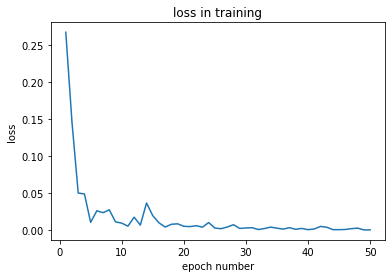

In [15]:
import matplotlib.pyplot as plt

x = [i for i in range(1, len(loss_history) + 1)]
    
# plotting the points   
plt.plot(x, loss_history)  
    
# naming the x axis  
plt.xlabel('epoch number')  
# naming the y axis  
plt.ylabel('loss')  
    
# giving a title to my graph  
plt.title('loss in training')  
    
# function to show the plot  
plt.show()  

In [16]:
#testing accuracy on test dataset
total_correct = 0
total_instances = 0

#chang back batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

pretrained_model.eval()
# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(train_loader):
      images = images.to(device)
      # labels = labels.float().to(device) # don't need this cuz we not training no more

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print("after training")
print(round(total_correct/total_instances, 3))

100%|██████████| 5400/5400 [02:26<00:00, 36.79it/s]

after training
1.0


In [21]:
#loading validation dataset
val_dataset = PlantDataset(data_dir, val, transform = transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [22]:
total_correct = 0
total_instances = 0

pretrained_model.eval()
# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(val_loader):
      images = images.to(device)
      # labels = labels.float().to(device) # don't need this cuz we not training no more

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print(round(total_correct/total_instances, 3))

100%|██████████| 112/112 [00:04<00:00, 24.47it/s]

1.0


In [23]:
#loading test dataset
test_dataset = PlantDataset(data_dir, test, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [24]:
total_correct = 0
total_instances = 0

pictures = []
model_guesses = []
correct_answers = []

# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(test_loader):
      pictures.append(images)
      images = images.to(device)

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()
      model_guesses.append(getLabel(classifications + 1)) # + 1 to convert from index to dict key

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]
      correct_answers.append(getLabel(label + 1)) # + 1 to convert from index to dict key

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print(round(total_correct/total_instances, 3))

100%|██████████| 113/113 [00:03<00:00, 31.56it/s]

0.991


In [25]:
#dump to pickle
import pickle
pickle.dump(pretrained_model, open('model3.pkl', 'wb'))